# Sentiment analysis

The goal for this assignment is to classify feelings in a text corpus. Each row has a sentence with corresponding emotion.

In [1]:
import pandas as pd
import string
import re
import seaborn as sns
import nltk
import matplotlib.pyplot as plt
import os 
import datetime
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense


from sklearn.model_selection import train_test_split


import ssl 
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context



nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

2024-01-09 22:50:57.145428: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/joeloscarsson/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/joeloscarsson/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/joeloscarsson/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
STOPWORDS_DEFAULT = nltk.corpus.stopwords.words('english')
LEMMATIZER = nltk.stem.WordNetLemmatizer()

FILE = "./data/emotions.csv"
LOGS_PATH = ("./logs")


EPOCHS = 30
INPUT_DIM = 3 # Size of the 

In [3]:
def get_separator():
    """ Returns a separator """
    print("======================================================")
    

def get_file():
    """ Get the file and return it as a pandas dataframe"""
    data = pd.read_csv(FILE)
    pd.set_option('display.max_colwidth', 200) # too be able to see more of the text
    return data

In [4]:
get_file()

,text,label
0,i feel so pissed off over an old friend and some friends,anger
1,ive found it has made a huge difference especially on the finger with my ring and the my skin feels so much softer and less irritated,anger
2,i also feel it is unfortunate that nearly all the readers of going to meet the man will be african americans unlike myself,sadness
3,i feel petty a href http clairee,anger
4,i used to believe that a feeling like fear was to be ignored or suppressed right away more on this in a moment,sadness
...,...,...
19995,i was i might be buying stuff from there but i feel the clothes are too casual,joy
19996,i like sonam deepika and genelia who i feel are very talented and beautiful,joy
19997,i feel pathetic that i can hardly go a whole day not talking to him,sadness
19998,id have spent more time with her on reading i feel a bit guilty about that,sadness


# Exploration of data


In [5]:
get_file().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    20000 non-null  object
 1   label   20000 non-null  object
dtypes: object(2)
memory usage: 312.6+ KB


In [6]:
get_file()['label'].unique()

array(['anger', 'sadness', 'joy', 'love', 'fear', 'surprise'],
      dtype=object)

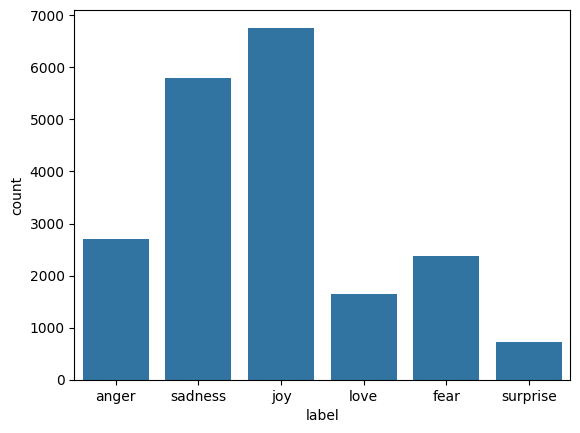

In [7]:
plot = get_file()

sns.countplot(plot, x='label');

We want to separate these 6 emotions into 3 categories because some of the feelings are similar. These categories are positive, negative and neutral. We want to group the emotions with corresponding category. 
This means we can re-label to new categories:

* Negative
    - 'anger'
    - 'sadness'
    - 'fear'

* Neutral
    - 'surprise'

* Positive
    - 'joy'
    - 'love'

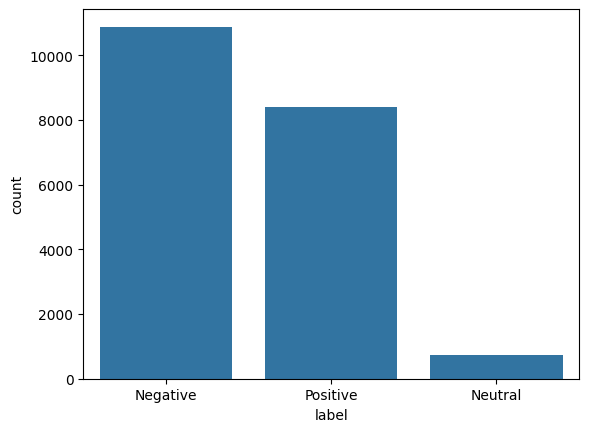

In [8]:
df =  get_file()

label_map = {
    'anger': 'Negative',
    'sadness': 'Negative',
    'fear': 'Negative',
    'surprise': 'Neutral',
    'joy': 'Positive',
    'love': 'Positive',
}

df['label'] = df['label'].map(label_map) # changes the names of the labels to suit the 3 classes

sns.countplot(df, x='label');

So the dataset is not balanced. So this might be an issue that might need to be investigated further if the models tends to be biased towards negative feelings. It might also introduce some challenges with the evaluation since it is not even. 



* TODO: Maybe check what the shortest amount of words is, and the most amount of the words in the data is and number of occurences. This is to know that padding the data is not introducing any dilation to my network and messes with the tanh acitvation function. 

# Tokenization

In [9]:
def get_clean_text(df):
    """"
    Takes in a df column "text" and:
    - converts everything to lowercase
    - removes punctuation
    - removes extra whitespaces
    - adjustes words like "ive", "ill", im" to its full form "i have", "i will", "i am"

    Returns: cleaned df
    
    """

    full_word_mapping = {
        'im': 'i am',
        'ive': 'i have',
        'ill': 'i will',
        'id': 'i would',
    }

    df['text'] = df['text'].replace(full_word_mapping, regex=True) # replaces the words to its full form

    df['text'] = df['text'].str.lower() # makes everything lowercase

    df['text'] = df['text'].apply(lambda x: ' '.join(x.split())) # removes the extra whitespaces

    df['text'] = df['text'].str.replace(f'[{string.punctuation}]', '', regex=True) # removes the punctuation
    

    return df

get_clean_text(df)

,text,label
0,i feel so pissed off over an old friend and some friends,Negative
1,i have found it has made a huge difference especially on the finger with my ring and the my skin feels so much softer and less irritated,Negative
2,i also feel it is unfortunate that nearly all the readers of going to meet the man wi will be african americans unlike myself,Negative
3,i feel petty a href http clairee,Negative
4,i used to believe that a feeling like fear was to be ignored or suppressed right away more on this in a moment,Negative
...,...,...
19995,i was i might be buying stuff from there but i feel the clothes are too casual,Positive
19996,i like sonam deepika and genelia who i feel are very talented and beautiful,Positive
19997,i feel pathetic that i can hardly go a whole day not talking to hi am,Negative
19998,i would have spent more ti ame with her on reading i feel a bit guilty about that,Negative


In [10]:
def tokenize(df):
    """"
    Takes in a df column

    Returns: column with the text tokenized and each row is corresponding to correct index
    
    """

    df['tokenized_text'] = df['text'].apply(nltk.word_tokenize) # tokenizes the text

    # tokenized_text = df['tokenized_text'].explode().reset_index() # transform each element and replicate index values to match each row. 


    # display(tokenized_text['index'].unique()) # this is to see that the index matches the original df rows (20K)

    return df

tokenize(df)

,text,label,tokenized_text
0,i feel so pissed off over an old friend and some friends,Negative,"[i, feel, so, pissed, off, over, an, old, friend, and, some, friends]"
1,i have found it has made a huge difference especially on the finger with my ring and the my skin feels so much softer and less irritated,Negative,"[i, have, found, it, has, made, a, huge, difference, especially, on, the, finger, with, my, ring, and, the, my, skin, feels, so, much, softer, and, less, irritated]"
2,i also feel it is unfortunate that nearly all the readers of going to meet the man wi will be african americans unlike myself,Negative,"[i, also, feel, it, is, unfortunate, that, nearly, all, the, readers, of, going, to, meet, the, man, wi, will, be, african, americans, unlike, myself]"
3,i feel petty a href http clairee,Negative,"[i, feel, petty, a, href, http, clairee]"
4,i used to believe that a feeling like fear was to be ignored or suppressed right away more on this in a moment,Negative,"[i, used, to, believe, that, a, feeling, like, fear, was, to, be, ignored, or, suppressed, right, away, more, on, this, in, a, moment]"
...,...,...,...
19995,i was i might be buying stuff from there but i feel the clothes are too casual,Positive,"[i, was, i, might, be, buying, stuff, from, there, but, i, feel, the, clothes, are, too, casual]"
19996,i like sonam deepika and genelia who i feel are very talented and beautiful,Positive,"[i, like, sonam, deepika, and, genelia, who, i, feel, are, very, talented, and, beautiful]"
19997,i feel pathetic that i can hardly go a whole day not talking to hi am,Negative,"[i, feel, pathetic, that, i, can, hardly, go, a, whole, day, not, talking, to, hi, am]"
19998,i would have spent more ti ame with her on reading i feel a bit guilty about that,Negative,"[i, would, have, spent, more, ti, ame, with, her, on, reading, i, feel, a, bit, guilty, about, that]"


# Remove stopwords

In [11]:
def remove_stopwords(df, STOPWORDS_DEFAULT):
    """ Remove stopwords from the tokenized text (df) """

    df['tokenized_text'] = df['tokenized_text'].apply(lambda words: [word for word in words if word not in STOPWORDS_DEFAULT])

    return

remove_stopwords(df, STOPWORDS_DEFAULT)

In [12]:
df

,text,label,tokenized_text
0,i feel so pissed off over an old friend and some friends,Negative,"[feel, pissed, old, friend, friends]"
1,i have found it has made a huge difference especially on the finger with my ring and the my skin feels so much softer and less irritated,Negative,"[found, made, huge, difference, especially, finger, ring, skin, feels, much, softer, less, irritated]"
2,i also feel it is unfortunate that nearly all the readers of going to meet the man wi will be african americans unlike myself,Negative,"[also, feel, unfortunate, nearly, readers, going, meet, man, wi, african, americans, unlike]"
3,i feel petty a href http clairee,Negative,"[feel, petty, href, http, clairee]"
4,i used to believe that a feeling like fear was to be ignored or suppressed right away more on this in a moment,Negative,"[used, believe, feeling, like, fear, ignored, suppressed, right, away, moment]"
...,...,...,...
19995,i was i might be buying stuff from there but i feel the clothes are too casual,Positive,"[might, buying, stuff, feel, clothes, casual]"
19996,i like sonam deepika and genelia who i feel are very talented and beautiful,Positive,"[like, sonam, deepika, genelia, feel, talented, beautiful]"
19997,i feel pathetic that i can hardly go a whole day not talking to hi am,Negative,"[feel, pathetic, hardly, go, whole, day, talking, hi]"
19998,i would have spent more ti ame with her on reading i feel a bit guilty about that,Negative,"[would, spent, ti, ame, reading, feel, bit, guilty]"


# Lemmatization
* Reduce the words to their base form. for instance "running" -> "run"

In [13]:
def lemmatize(df, lemmatizer):
    """ Lemmatize list of words in the tokenized_text column df """

    df['tokenized_text'] = df['tokenized_text'].apply(lambda words: [lemmatizer.lemmatize(word) for word in words])
    
    return df


lemmatize(df, LEMMATIZER)
    

,text,label,tokenized_text
0,i feel so pissed off over an old friend and some friends,Negative,"[feel, pissed, old, friend, friend]"
1,i have found it has made a huge difference especially on the finger with my ring and the my skin feels so much softer and less irritated,Negative,"[found, made, huge, difference, especially, finger, ring, skin, feel, much, softer, le, irritated]"
2,i also feel it is unfortunate that nearly all the readers of going to meet the man wi will be african americans unlike myself,Negative,"[also, feel, unfortunate, nearly, reader, going, meet, man, wi, african, american, unlike]"
3,i feel petty a href http clairee,Negative,"[feel, petty, href, http, clairee]"
4,i used to believe that a feeling like fear was to be ignored or suppressed right away more on this in a moment,Negative,"[used, believe, feeling, like, fear, ignored, suppressed, right, away, moment]"
...,...,...,...
19995,i was i might be buying stuff from there but i feel the clothes are too casual,Positive,"[might, buying, stuff, feel, clothes, casual]"
19996,i like sonam deepika and genelia who i feel are very talented and beautiful,Positive,"[like, sonam, deepika, genelia, feel, talented, beautiful]"
19997,i feel pathetic that i can hardly go a whole day not talking to hi am,Negative,"[feel, pathetic, hardly, go, whole, day, talking, hi]"
19998,i would have spent more ti ame with her on reading i feel a bit guilty about that,Negative,"[would, spent, ti, ame, reading, feel, bit, guilty]"


# Assign a unique number to each unique word

- We need to assign a unique number to each unique word to vectorize it.
- Also i change the labels positive/neutral/negative to numerical numbers

In [14]:
def id_each_unique_word(df):
    """" 
    Mapping each unique word to an id
    
    Returns: 
    - word_to_id (maps the words to an id) 
    - id_to_word (maps the id to a word)
    
    """

    index_each_word = df['tokenized_text'].explode().unique()

    word_to_id = {}
    id_to_word = {}


    for i, token in enumerate(set(index_each_word)):
        word_to_id[token] = i
        id_to_word[i] = token


    print(f'Unique words in the text: {len(word_to_id)}')
    display(word_to_id)

    return word_to_id, id_to_word


word_to_id, id_to_word = id_each_unique_word(df)


def change_label_to_int(df):
    """ Change the labels column positive, neutral, negative to ints """

    df['label'] = df['label'].replace({'Negative': -1, 'Neutral': 0, 'Positive': 1})

    return

change_label_to_int(df)

Unique words in the text: 14970


{'blogger': 0,
 'pole': 1,
 'prisoner': 2,
 'wtf': 3,
 'squeezed': 4,
 'weighins': 5,
 'charlie': 6,
 'rep': 7,
 'snoozing': 8,
 'eaaaat': 9,
 'tactic': 10,
 'deeply': 11,
 'vertigo': 12,
 'music': 13,
 'lacking': 14,
 'destroyer': 15,
 'expressing': 16,
 'complicated': 17,
 'fancy': 18,
 'proclai': 19,
 'martinez': 20,
 'rebuild': 21,
 'libi': 22,
 'vintage': 23,
 'lightly': 24,
 'majority': 25,
 'ambushed': 26,
 'fabulous': 27,
 'fate': 28,
 'speed': 29,
 'overthink': 30,
 'hung': 31,
 'freakin': 32,
 'itge': 33,
 'grumbling': 34,
 'center': 35,
 'roberto': 36,
 'crushed': 37,
 'reelected': 38,
 'messaging': 39,
 'club': 40,
 'remarkably': 41,
 'reed': 42,
 'traveling': 43,
 'tatsuma': 44,
 'continued': 45,
 'goin': 46,
 'modest': 47,
 'birthed': 48,
 'representing': 49,
 'hsp': 50,
 'columbus': 51,
 'boss': 52,
 'realness': 53,
 'semi': 54,
 'fir': 55,
 'scum': 56,
 'collapse': 57,
 'formed': 58,
 'signal': 59,
 'occassionally': 60,
 'hahaha': 61,
 'proffer': 62,
 'harvesting': 63,


In [15]:
df

,text,label,tokenized_text
0,i feel so pissed off over an old friend and some friends,-1,"[feel, pissed, old, friend, friend]"
1,i have found it has made a huge difference especially on the finger with my ring and the my skin feels so much softer and less irritated,-1,"[found, made, huge, difference, especially, finger, ring, skin, feel, much, softer, le, irritated]"
2,i also feel it is unfortunate that nearly all the readers of going to meet the man wi will be african americans unlike myself,-1,"[also, feel, unfortunate, nearly, reader, going, meet, man, wi, african, american, unlike]"
3,i feel petty a href http clairee,-1,"[feel, petty, href, http, clairee]"
4,i used to believe that a feeling like fear was to be ignored or suppressed right away more on this in a moment,-1,"[used, believe, feeling, like, fear, ignored, suppressed, right, away, moment]"
...,...,...,...
19995,i was i might be buying stuff from there but i feel the clothes are too casual,1,"[might, buying, stuff, feel, clothes, casual]"
19996,i like sonam deepika and genelia who i feel are very talented and beautiful,1,"[like, sonam, deepika, genelia, feel, talented, beautiful]"
19997,i feel pathetic that i can hardly go a whole day not talking to hi am,-1,"[feel, pathetic, hardly, go, whole, day, talking, hi]"
19998,i would have spent more ti ame with her on reading i feel a bit guilty about that,-1,"[would, spent, ti, ame, reading, feel, bit, guilty]"


# Word Embedding

In [23]:
def text_to_sequence(word_to_id):
    """ 
    Convert sentences to sequences from word_of_id mapping
      
    Returns: sequence of ints where each sequence corresponds to a sentence
      
    """

    sequences = []


    for index, sentence in enumerate(df['tokenized_text']):

        # for each word in the sentence get the corresponding id from mapping and put in list, if not found return None
        seq = [word_to_id.get(word, None) for word in sentence]
        sequences.append(seq)

        if index < 5: # 5 examples to make sure its correct converted
            print(f"Sentence {index+1}: {sentence}")
            get_separator
            print(f"Converted to Sequence: {index+1}: {seq}")
            get_separator()


    return sequences


sequences = text_to_sequence(word_to_id)


print(f'Amount of text sequences (rows): {len(sequences)}') 


Sentence 1: ['feel', 'pissed', 'old', 'friend', 'friend']
Converted to Sequence: 1: [13985, 6798, 9567, 14854, 14854]
Sentence 2: ['found', 'made', 'huge', 'difference', 'especially', 'finger', 'ring', 'skin', 'feel', 'much', 'softer', 'le', 'irritated']
Converted to Sequence: 2: [12097, 5051, 13969, 2016, 3282, 7622, 6763, 5525, 13985, 2167, 9391, 4629, 12078]
Sentence 3: ['also', 'feel', 'unfortunate', 'nearly', 'reader', 'going', 'meet', 'man', 'wi', 'african', 'american', 'unlike']
Converted to Sequence: 3: [6291, 13985, 5916, 645, 9802, 3483, 6983, 4746, 3793, 9444, 9464, 13292]
Sentence 4: ['feel', 'petty', 'href', 'http', 'clairee']
Converted to Sequence: 4: [13985, 9773, 1140, 14360, 7486]
Sentence 5: ['used', 'believe', 'feeling', 'like', 'fear', 'ignored', 'suppressed', 'right', 'away', 'moment']
Converted to Sequence: 5: [14967, 13369, 640, 13900, 8869, 4428, 7204, 9627, 6619, 93]
Amount of text sequences (rows): 20000


# Padding

In [17]:
def get_seq_length(sequences):
    """ Get the length of the maximum sequence in the sequences list to determine padding """
    max_length = max(len(sequence) for sequence in sequences)
    min_length = min(len(sequence) for sequence in sequences)
    mean_length = sum(map(len, sequences)) / len(sequences)

    print(f'Max sequence length: {max_length}')
    print(f'Min sequence length: {min_length}')
    print(f'Mean sequence length: {mean_length}')

    return max_length, min_length, mean_length


def pad_data(sequences, max_length):
    """ Pad the sequences to the max length """

    padded_sequences = []

    for sequence in sequences:
        padded_sequence = sequence + [0] * (max_length - len(sequence)) # padding the sequences with 0 (neutral label)
        padded_sequences.append(padded_sequence)

    return padded_sequences


# investigating so the padding works as intented
og_max_length, og_min_length, og_mean_length = get_seq_length(sequences)
get_separator()
padded_sequences = pad_data(sequences, og_max_length)
max_length, min_length, mean_length = get_seq_length(padded_sequences)


Max sequence length: 38
Min sequence length: 1
Mean sequence length: 9.55455
Max sequence length: 38
Min sequence length: 38
Mean sequence length: 38.0


Note that the paddding might affect the overall model and further deep diving into the text data itself is needed. But it's not the priority for me in this assignment, the goal is to follow the whole workflow and create a model from scratch for learning. For instance some words that are misspelled i haven't done anything about either, and this will also affect the model.

In [25]:
def get_train_test_val(df, padded_sequences):
    """ 
    Converts and aligns the padded sequence and the labels to a numpy array.
    Then splits up the data.

    Takes in:
    - padded_sequence(list)
    - df['labels'] 

    Returns: train, test, val split of the data

    """

    # Converting to numpy arrays, these lists are in the same order
    np_seq = np.array(padded_sequences)
    np_labels = np.array(df['label'].values)


    # Splitting the data into:
    # - train (60%)
    # - test (20%)
    # - validation (20% of train data)

    X_train, X_test, y_train, y_test = train_test_split(np_seq, np_labels, test_size=0.2, random_state=137)

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=137)


    return X_train, X_test, X_val, y_train, y_test, y_val


X_train, X_test, X_val, y_train, y_test, y_val = get_train_test_val(df, padded_sequences)


def check_x_shape(X_train, X_test, X_val, y_train, y_test, y_val):
    """ Check the shape of the arrays """

    print(f'X_train shape: {X_train.shape}')
    print(f'X_test shape: {X_test.shape}')
    print(f'X_val shape: {X_val.shape}')
    print(f'y_train shape: {y_train.shape}')
    print(f'y_test shape: {y_test.shape}')
    print(f'y_val shape: {y_val.shape}')


def check_alignment():
    """ Check and inspect the array """
    for i in range(5):
        get_separator()
        print("Sequence:", X_train[i])
        print("Label:", y_train[i])
    
    get_separator()

check_x_shape(X_train, X_test, X_val, y_train, y_test, y_val)

X_train shape: (12000, 38)
X_test shape: (4000, 38)
X_val shape: (4000, 38)
y_train shape: (12000,)
y_test shape: (4000,)
y_val shape: (4000,)


In [26]:
check_alignment()

Sequence: [13985 10509  5139 11343 12476  4423 11352  9750     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0]
Label: 1
Sequence: [13985  3610  9138    93     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0]
Label: -1
Sequence: [13985   449 10100     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0]
Label: -1
Sequence: [13985   121  7390  6540  2052 14599  8283  8172  2546  4170     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0]

TODO: input_dim is equal 38  ( equal to the length padded_sequence)
TODO: Vocab_size is the len of word_to_id
TODO: hidden_dim (????)


TODO: Split up the data and so they correspond with the label from the dataframe

# Next is padding the data?
But what do i with the labels? And split up the data and labels (And i need to make sure that the labels follow correct sentence)


# use constant padding since its 0 and affects the model as little as possible.



# My choice in the model is gonna be an RNN network. Since i think even though its a multiclass classficiation problem. I only have 3 classes so its not that complex i hope. And also i am combating the vanishing gradient problem by using tanh as the activation function. 

In [19]:
print(df.columns)
www

Index(['text', 'label', 'tokenized_text'], dtype='object')


NameError: name 'www' is not defined

In [ ]:
import tensorflow as tf

class RNNCell(tf.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        # Initialize weights and biases
        self.Wxh = tf.Variable(tf.random.normal([input_dim, hidden_dim]))
        self.Whh = tf.Variable(tf.random.normal([hidden_dim, hidden_dim]))
        self.bh = tf.Variable(tf.zeros([hidden_dim]))

    def __call__(self, x, h):
        # Compute the next hidden state
        h_next = tf.tanh(tf.matmul(x, self.Wxh) + tf.matmul(h, self.Whh) + self.bh)
        return h_next

class MyRNNModel(tf.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim=1, sequence_length=100):
        super().__init__()
        # Embedding layer
        self.embedding = tf.Variable(tf.random.normal([vocab_size, embedding_dim]))
        # RNN Cell
        self.rnn_cell = RNNCell(embedding_dim, hidden_dim)
        # Output layer weights and biases
        self.Why = tf.Variable(tf.random.normal([hidden_dim, output_dim]))
        self.by = tf.Variable(tf.zeros([output_dim]))

    def __call__(self, x):
        # Embedding lookup
        x = tf.nn.embedding_lookup(self.embedding, x)
        # Initial hidden state (zeros)
        h = tf.zeros([x.shape[0], self.rnn_cell.Whh.shape[0]])

        # Process the input sequence
        for t in range(sequence_length):
            x_t = x[:, t, :]
            h = self.rnn_cell(x_t, h)

        # Compute the output
        y = tf.matmul(h, self.Why) + self.by
        return tf.sigmoid(y)

# Define loss function and optimizer
loss_function = tf.losses.BinaryCrossentropy()
optimizer = tf.optimizers.Adam()

def train_step(model, inputs, targets, clip_norm=1.0):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = loss_function(targets, predictions)
    
    gradients = tape.gradient(loss, model.trainable_variables)
    gradients = [tf.clip_by_norm(g, clip_norm) for g in gradients]  # Gradient clipping
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

# Example usage
# Define your model, dataset, and training loop


In [ ]:
from keras.preprocessing.sequence import pad_sequences
import pandas as pd
from tensorflow.keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import train_test_split

def pad_data(sequences):
    # Find the maximum sequence length
    max_seq_length = max(len(s) for s in sequences)

    # Pad the sequences to ensure uniform length
    padded_sequences = pad_sequences(sequences, maxlen=max_seq_length, padding='post')

    return padded_sequences, max_seq_length


padded_sequences, max_seq_length = pad_data(sequences)



from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Define model parameters
vocab_size = len(word_to_id)  # Total number of unique words
embed_size = 100  # Size of the embeddings

# Adjust the model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=max_seq_length))
model.add(LSTM(50))
model.add(Dense(27, activation='tanh'))
model.add(Dense(9, activation='tanh'))
model.add(Dense(3, activation='tanh'))


# I am using tanh since activation since it introduces non-linearity to the model and it is good for classification problems. The curve goes from -1 to 1 and it is good considering positive, neutral and negative.
# S

model.compile(optimizer='adam', loss='categorial_crossentrop', metrics=['accuracy'])


from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split

# Splitting the data into train and test sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df['label'], test_size=0.2, random_state=42)

# Splitting the training data into train and validation sets (e.g., 80% train, 20% validation of the original training data)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2



2024-01-09 17:03:28.307898: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# Train the model
history = model.fit(X_train, y_train,
                    epochs=NUM_EPOCHS,              # Number of epochs
                    batch_size=32,          # Size of each batch
                    validation_data=(X_val, y_val))  # Validation data to monitor performance



Epoch 1/30
375/375 [==============================] - 12s 27ms/step - loss: 0.6872 - accuracy: 0.1715 - val_loss: 0.2195 - val_accuracy: 0.3918
Epoch 2/30
375/375 [==============================] - 9s 24ms/step - loss: 0.1148 - accuracy: 0.4134 - val_loss: 0.1535 - val_accuracy: 0.4175
Epoch 3/30
375/375 [==============================] - 9s 25ms/step - loss: 0.0456 - accuracy: 0.4352 - val_loss: 0.1185 - val_accuracy: 0.4150
Epoch 4/30
375/375 [==============================] - 9s 23ms/step - loss: 0.0268 - accuracy: 0.4420 - val_loss: 0.1103 - val_accuracy: 0.4353
Epoch 5/30
375/375 [==============================] - 10s 26ms/step - loss: 0.0256 - accuracy: 0.4454 - val_loss: 0.2796 - val_accuracy: 0.4358
Epoch 6/30
375/375 [==============================] - 10s 26ms/step - loss: 0.1423 - accuracy: 0.3992 - val_loss: 0.2348 - val_accuracy: 0.4142
Epoch 7/30
375/375 [==============================] - 9s 25ms/step - loss: 0.0748 - accuracy: 0.4212 - val_loss: 0.1984 - val_accuracy: 0.4

In [ ]:

def save_history(history, X_train, y_train, X_val, y_val, NUM_EPOCHS, NUM_EPOCHS):
    time = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    file = (f'history_{NUM_EPOCHS}_{time}.npy')
    file = os.path.join(LOGS_PATH, file)

    
    # Create logs folder if it does not exist
    if not LOGS_PATH.exists:
        os.makedirs('logs')


    np.save(file, history.history) # saves history as a dict with key values

    model.save('model/model_1.h5')  #TODO generalize this solution
    
    # np.save('logs/history.npy', history.history)
    
    get_separator()
    print(f'Saved training history to: {file}')
    get_separator()
    return history, save_history(history)

# train_model(model, X_train, y_train, X_val, y_val, NUM_EPOCHS)



In [ ]:
# Plots metrics over training history
def plot_metrics(metrics):
    _, ax = plt.subplots(1, 2, figsize=(15, 5))
    metrics[['loss', 'val_loss']].plot(ax=ax[0], title='Loss', grid=True)
    metrics[['accuracy', 'val_accuracy']].plot(ax=ax[1], title='Accuracy', grid=True) 

plot_metrics(df)

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


125/125 [==============================] - 1s 8ms/step - loss: 0.1333 - accuracy: 0.4378
Test Loss: 0.13325612246990204
Test Accuracy: 0.4377500116825104
